In [45]:
import tensorflow as tf
#tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import cv2
# USED MODEL
from tensorflow.keras.applications import vgg19

In [46]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# zaczniemy od przekopiowania stylu dwurnika na zdjęcie takie samo jak jego obraz 
plac_zbawiciela_dwur_loc = './obrazy/Portrety/Lempicka/Autoportret_w_zielonym_bugatti.jpg'
plac_zbawiciela_real_loc = './obrazy/Portrety/Karolina_2.jpg'

In [6]:
# funkcje obsługujące obrazy wynikiem jest tablica np.array
def load_image(location):
    image = cv2.imread(location)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.array(image)

        
# funkcja wyświetlająco obrazy w rzędzie, można podac listę obrazów do wyświetlenia 
def plot_images(images, num_rows = 1):
    n = len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols = int(num_cols),nrows = int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

(533, 341, 3)
(2048, 1147, 3)


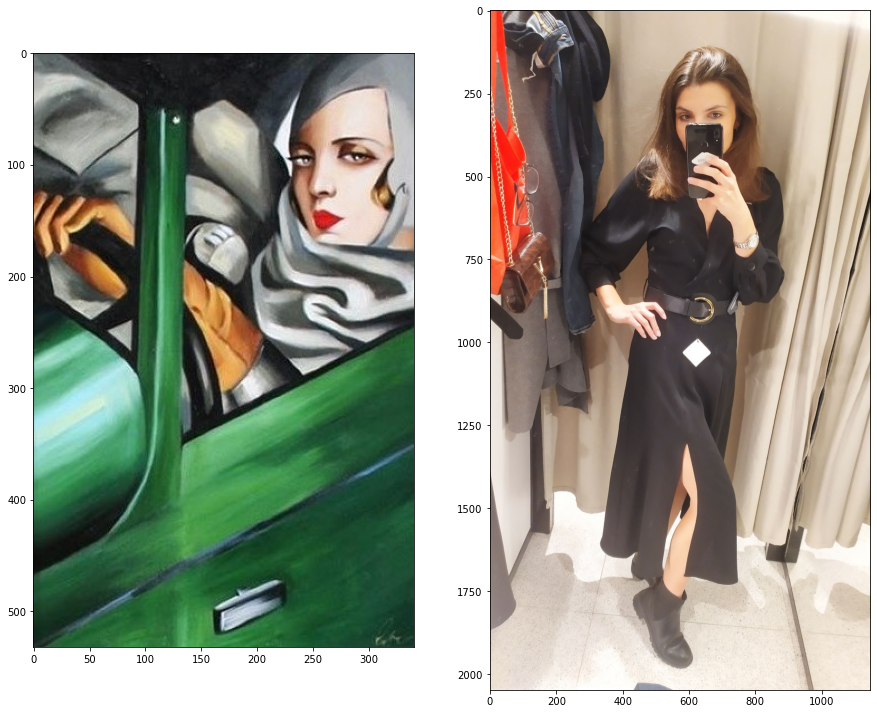

In [7]:
# load and disply images 
plac_zbawiciela_dwur_img = load_image(plac_zbawiciela_dwur_loc)
plac_zbawiciela_real_img = load_image(plac_zbawiciela_real_loc)

print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

(900, 500, 3)
(900, 500, 3)
(900, 500, 3)


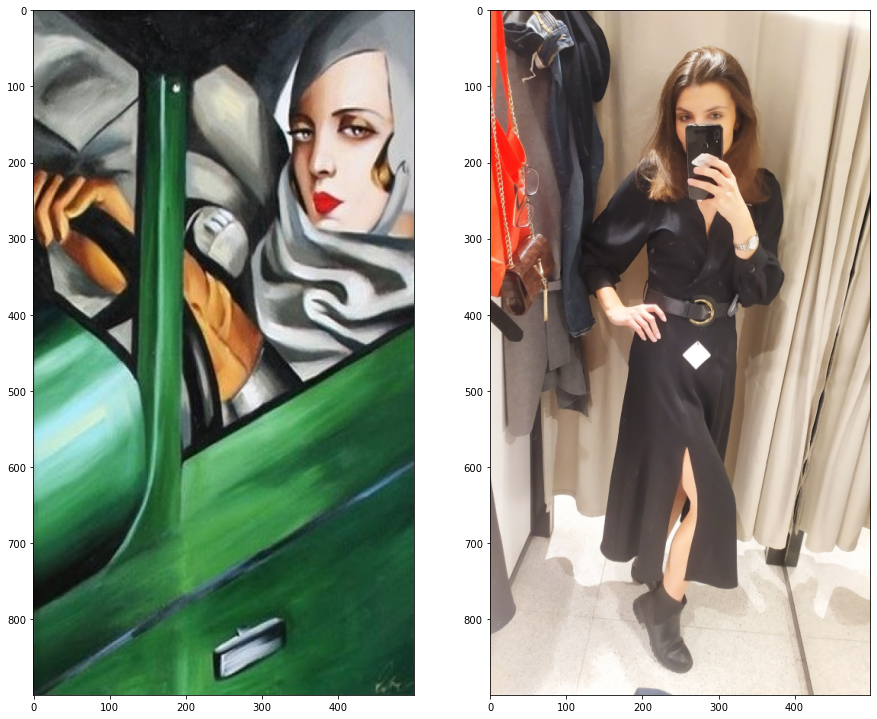

In [8]:
# obcięcie rozmiaru zdjęć do kwadratu i zmniejszenie
plac_zbawiciela_real_img = cv2.resize(plac_zbawiciela_real_img, 
                                      (500,900), interpolation = cv2.INTER_AREA)

plac_zbawiciela_dwur_img = cv2.resize(plac_zbawiciela_dwur_img, 
                                      (500,900), interpolation = cv2.INTER_AREA)
                                      
print(plac_zbawiciela_dwur_img.shape)
print(plac_zbawiciela_real_img.shape)

#plac_zbawiciela_dwur_img = np.array(plac_zbawiciela_dwur_img.resize((500,500)))

print(plac_zbawiciela_dwur_img.shape)

plot_images([plac_zbawiciela_dwur_img, plac_zbawiciela_real_img])

In [9]:
# import i uruchomienie modelu 
base_model = vgg19.VGG19(include_top=False, weights='imagenet')
print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

#### Sprawdzenie jak będzie wyglądał przetworzony obraz

In [10]:
# dwa obrzy są używane, jeden to style [obraz artysty], a drugi to content [przetwarzane zdjęcie]
style_image = plac_zbawiciela_dwur_img
content_image = plac_zbawiciela_real_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 900, 500, 3)
(900, 500, 3)
<class 'numpy.ndarray'>


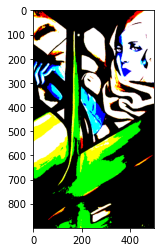

In [11]:
# sprawdzenie przetwarzania któe wykonuje sieć
process_example_img = vgg19.preprocess_input(np.expand_dims(style_image, axis=0))
print(process_example_img.shape)
print(process_example_img[0].shape)
print(type(process_example_img))

plt.imshow(process_example_img[0])

# jest ok, dodaliśmy jeden wymiar do obrazu, sztucznie bo sieć wymaga dodatkowych wejść, 
# widać jednak, że zmieniły się bardzo kolory, i taki zmienionybędzie obraz wyjściowy, 
# po pierwsze mamy zastosowane do kanałów koloru biasy, dodatkowo, zmieniana jest RGB na BGR
# od razu warto dopisać funkcję odwracającą zmiany kolorów

In [12]:
# sprawdzenie wartości biasów
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))
# funkcja deprocessu
def deprocess (start_image):
    fin_image = start_image - VGG_BIASES
    fin_image = tf.unstack(fin_image,axis=-1)
    fin_image = tf.stack([fin_image[2],fin_image[1],fin_image[0]],axis=-1)
    return fin_image

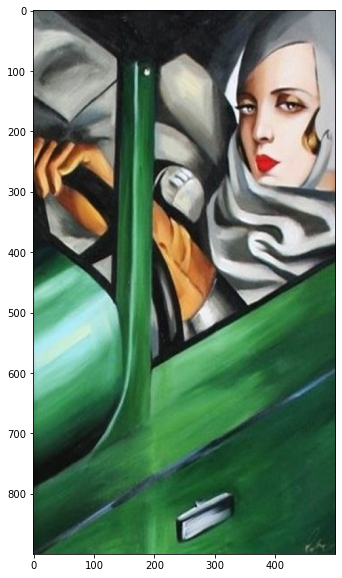

In [13]:
# sprawdzenie działania funkcji odwracającej działanie sieci na obrazie wyjściowym
plt.figure(figsize=(10,10))
plt.imshow(deprocess(process_example_img[0])/255)

### Tworzenie modelu to pobrania stylu 
W modelu style transfer po wstepnym nauczeniu sieci stosujemy sieć i jej części gdzie zapisane są cechy główne do zmiany obrau wejściowego. Ta operacja powtarza się wielokrotnie.

In [14]:
CONTENT_LAYERS = ["block5_conv2"] # przykładowa warstwa z której pobierzemy kontent po jednym obrocie
STYLE_LAYERS = ["block4_conv1",
                "block4_conv2",
                "block4_conv3",
                "block4_conv4"] # te warstwy zawierają cechy stylu

In [15]:
# zdefiniowanie modeli do testów, pełnego VGG19, bez pierwszych warstw i dla różnych rozmiarów
def make_model(full=False, in_shape=None):
    if full:    
        base_model = vgg19.VGG19(inclued_top=True, weights='imegenet')
        return base_model
    if in_shape != None:
        base_model = vgg19.VGG19(inclued_top=False, input_shape=in_shape, weights='imegenet')
    else:
        base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    # w metodzie style transfer, optymalizację nie wykonujemy na modelu, ale na obrazie transformowanym 
    base_model.trainable = False
    content_layers = CONTENT_LAYERS
    style_layers = STYLE_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

In [16]:
# stworzenie modelu 
base_model = make_model()

In [17]:
# aby użyć przerobionego modelu VGG19 należy na wejścia podać przeprocesowane obrazy 
processed_dwur_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_dwur_img, axis = 0))
processed_real_img = vgg19.preprocess_input(np.expand_dims(plac_zbawiciela_real_img, axis = 0))

In [18]:
# otrzymanie pierwszych danych wyjściowych
outputs_dwur_img = base_model(processed_dwur_img)
outputs_real_img = base_model(processed_real_img)

In [19]:
# wyciągnięcie odpowiednichcech stylu z obrazów
content_dwur_img = outputs_dwur_img[0]
content_real_img = outputs_real_img[0]

#### Teraz nalezy zbudować odpowiednią funkcję porównania stylu i kontentu 
użyta zostanie tutaj macierz Gramma do różnicy styli obu obrazów oraz zwykła MSE do różnicy kontentów
MSE ma posłużyć zachowaniu oryginalnego wyglądu kontentu (np. pies ma zostać psem, ale o zmienionym stylu)

In [20]:
# funkcja straty kontentu między dwoma obrazami MSE
def content_loss(img_new, img_base):
    return np.mean(np.square(img_new - img_base))

In [21]:
# funkcja straty stylu, implementację wziąłem z internetu
# w skrócie macierz Gramma to macierz wszystkich możliwych relacji między cechami obrazu
def gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1]))
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a = True)
    n = gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n

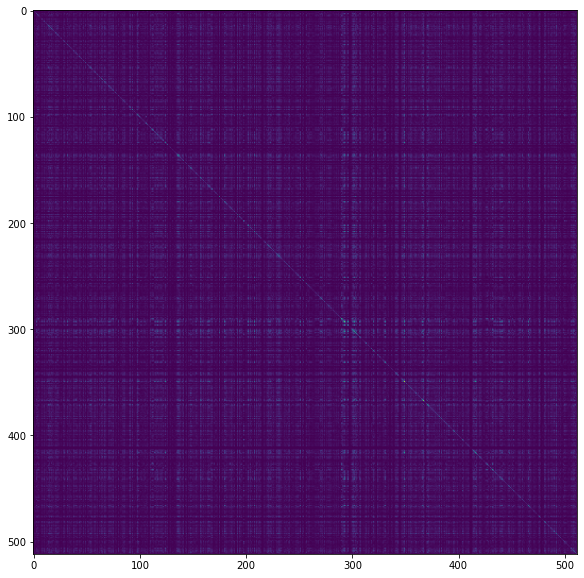

In [22]:
# Macierz dla warstw styli które wyciągnęliśmy z obrazu stylu
gram_matrix_img, N = gram_matrix(outputs_dwur_img[2])

plt.figure(figsize=(10,10))
plt.imshow(gram_matrix_img.numpy())

In [23]:
def style_loss(style_new, style_base):
    style_new_gram, gram_height1 = gram_matrix(style_new)
    style_base_gram, gram_height2 = gram_matrix(style_base)
    assert gram_height1 == gram_height2
    num_features = style_new_gram.shape[0]
    loss = tf.reduce_sum(tf.square(style_base_gram-style_new_gram)/(4*int(gram_height1)**2)*(int(num_features)**2))
    return loss
    

In [24]:
# połącznie błędu kontentu i stylu 
# współczynnik pozwoli na dopasowanie stosunku wagi stylu do zachowania kontentu
def total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss_val = 0
    N = len(new_image_styles)
    for i in range(N):
        style_loss_val += style_loss(new_image_styles[i], base_image_styles[i])   
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss_val = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss_val += content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss_val+alpha*content_loss_val

In [25]:
# strata przetworzenia pierwszej rotacji 
total_loss(outputs_dwur_img, outputs_real_img, outputs_dwur_img)

<tf.Tensor: shape=(), dtype=float32, numpy=2987.7117>

### Training
Po przygotowaniu wszystkich elementów można uruchomić procedurę przetwarzania obrazu 

In [26]:
base_style_outputs = base_model(processed_dwur_img)
base_content_outputs = base_model(processed_real_img)

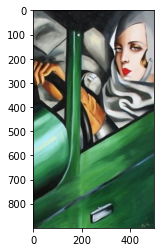

In [27]:
plt.imshow(deprocess(processed_dwur_img[0])/255)

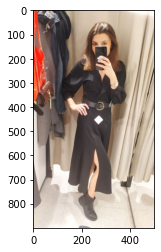

In [28]:
plt.imshow(deprocess(processed_real_img[0])/255)

In [29]:
# !!!! Można spróbować dodać trochę szumu do tego, żeby obraz lepiej poddał się content loss !!!!!
# +tf.random.normal(processed_real_img.shape)
processed_content_var = tf.Variable(processed_real_img+tf.random.normal(processed_real_img.shape))

In [30]:
optimizer = tf.keras.optimizers.Adam(5, beta_1=.99, epsilon=1e-3)

In [31]:
from IPython.display import display,clear_output

In [32]:
images = []
losses = []
i = 0 
# na początek coś dużego, tak o dla ogarnięcia jak to wyjdzie
best_loss = 200000
min_vals = VGG_BIASES
max_vals = VGG_BIASES + 255

for i in range(1000):
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = total_loss(content_var_outputs,base_content_outputs,base_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        # obcinamy do wartości dopuszczalnych, po deprocessingu muszą być rozpownawalne
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)       
        if i%5 == 0:
            images.append(deprocess(processed_content_var))
        if loss < best_loss:
            # nadajemy nowy loss jako best i przypisujemy best_img
            best_image = processed_content_var
            best_loss=loss    
        clear_output(wait=True)
        print(loss)
        print(i)

tf.Tensor(550369000000000.0, shape=(), dtype=float32)
128


KeyboardInterrupt: 

In [33]:
len(images)

26

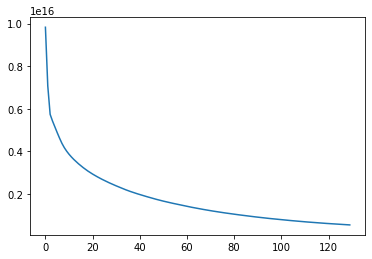

In [34]:
plt.plot(losses)

In [35]:
images[:][0].shape

TensorShape([1, 900, 500, 3])

In [36]:
frame = (images[0][0]/255).numpy()
cv2.imshow('video',frame)
height, width, channels = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter('./GIFY/Pomarancze_Michal_3', fourcc, 20.0, (width, height))

for image in images[:][0]:
    print(image.shape)
    image = image.numpy().reshape((600, 500, 3))
    out.write(image) # Write out frame to video

    
out.release()
cv2.destroyAllWindows()


(900, 500, 3)


ValueError: cannot reshape array of size 1350000 into shape (600,500,3)

In [37]:
from matplotlib.animation import FuncAnimation

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

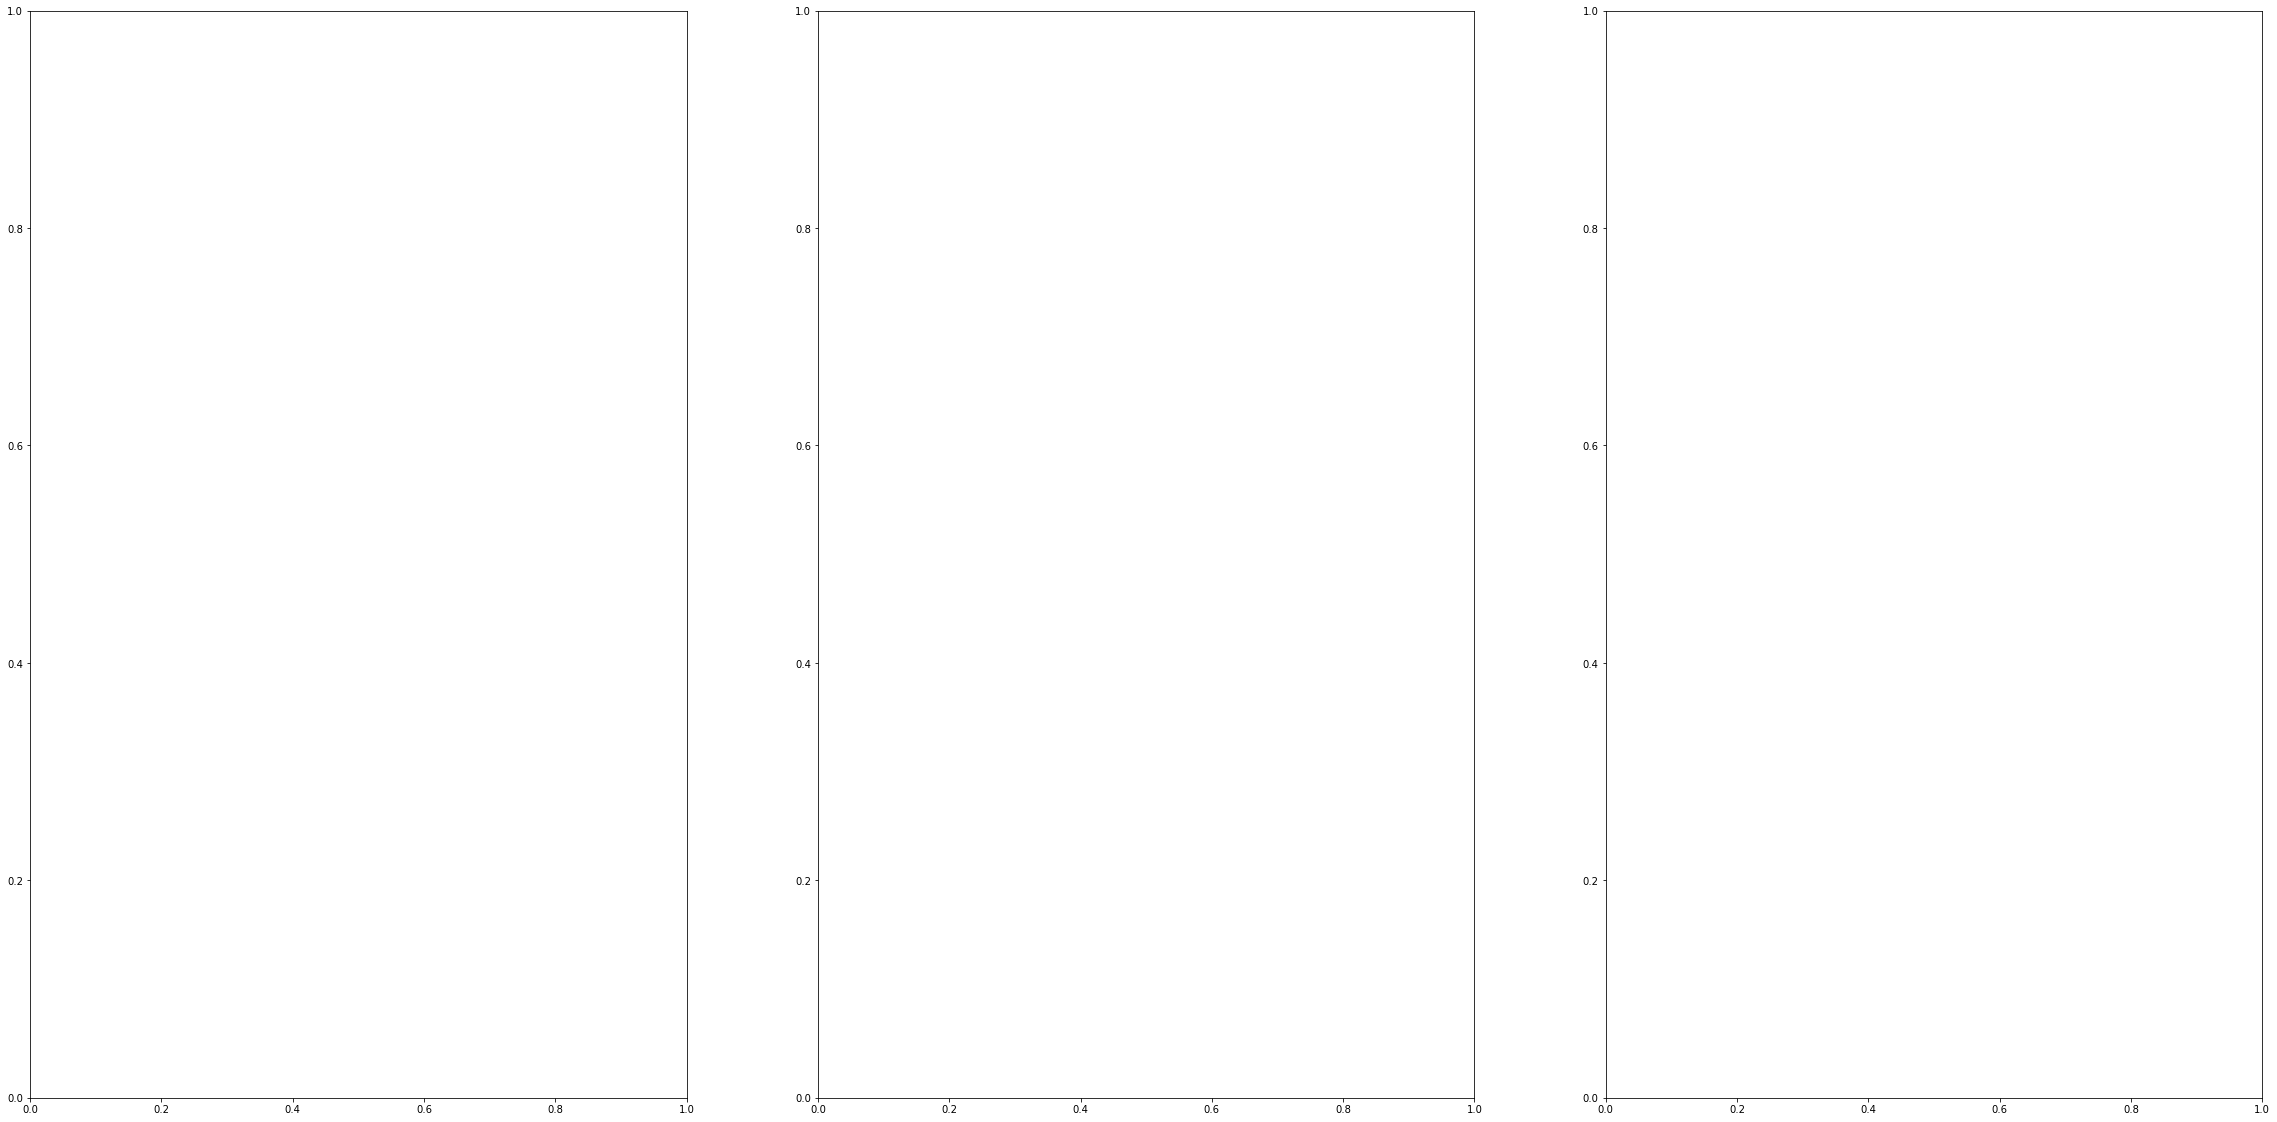

In [38]:
fig, ax = plt.subplots(ncols = 3,nrows = 1,figsize=(40, 20))
def update(i):
    im_normed = images[i].numpy().reshape((900, 700, 3))/255
    ax[0].imshow(im_normed)
    ax[1].imshow(plac_zbawiciela_real_img)
    ax[2].imshow(plac_zbawiciela_dwur_img)
    ax[0].set_title("Loss: {:.4e}, {}".format(losses[i], i), fontsize=20)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    print(i)
anim = FuncAnimation(fig, update, frames=np.arange(0, len(images)), interval=100)
anim.save('./GIFY/Pomarancze_Michal.gif', dpi=80, writer='ffmpeg')
plt.close()

<Figure size 2160x2160 with 0 Axes>

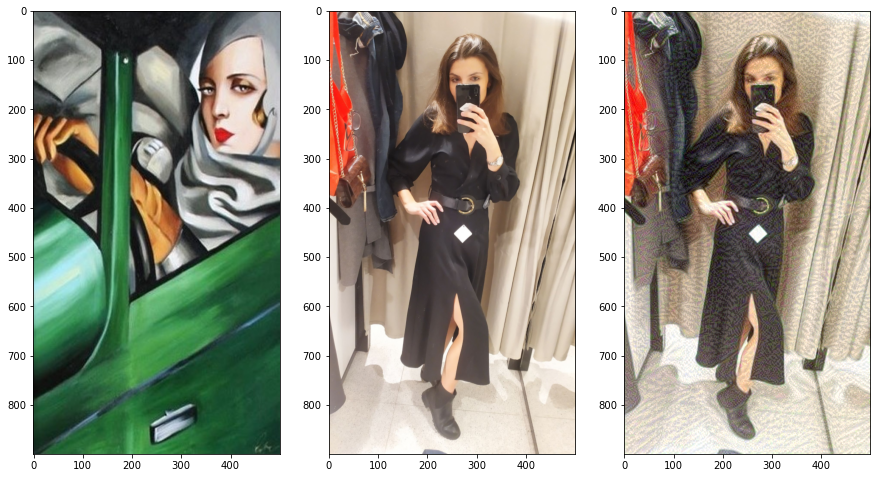

In [39]:
image_deproc = images[1][0]

plt.figure(figsize=(30,30))
plot_images([plac_zbawiciela_dwur_img,plac_zbawiciela_real_img,image_deproc/255])

<Figure size 2160x1080 with 0 Axes>

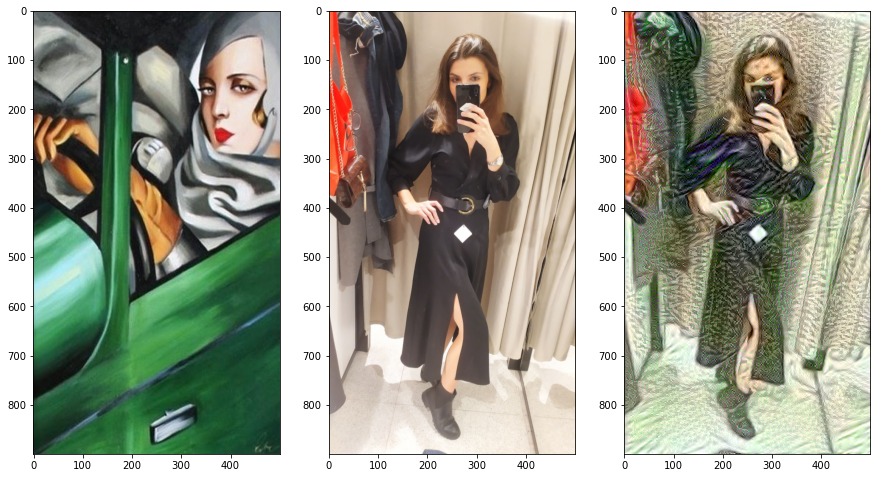

In [40]:
image_deproc = images[10][0]

plt.figure(figsize=(30,15))
plot_images([plac_zbawiciela_dwur_img,plac_zbawiciela_real_img,image_deproc/255])

In [41]:
image_deproc = images[199][0]

plt.figure(figsize=(50,30))
plot_images([plac_zbawiciela_dwur_img,plac_zbawiciela_real_img,image_deproc/255])

IndexError: list index out of range